In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import os
import tensorflow as tf
import lime
import tensorflow.keras.preprocessing.image as tf_image
from skimage.io import imread
from IPython.display import Image
from skimage.segmentation import mark_boundaries


main_dir = os.path.normpath(os.getcwd() + os.sep + os.pardir)
train_dir = os.path.join(main_dir, 'train')
test_dir = os.path.join(main_dir, 'test')
print(main_dir)

BATCH_SIZE = 32
IMG_SIZE = (224, 224)

print("train: ",train_dir)
train_dataset = tf.keras.utils.image_dataset_from_directory(train_dir,
                                                            validation_split=0.2,
                                                            subset="training",
                                                            seed=123,
                                                            batch_size=BATCH_SIZE,
                                                            image_size=IMG_SIZE)

validation_dataset = tf.keras.utils.image_dataset_from_directory(train_dir,
                                                            validation_split=0.2,
                                                            subset="validation",
                                                            seed=123,
                                                            batch_size=BATCH_SIZE,
                                                            image_size=IMG_SIZE)

print("test: ",test_dir)
test_dataset = tf.keras.utils.image_dataset_from_directory(test_dir,
                                                                 shuffle=True,
                                                                 batch_size=BATCH_SIZE,
                                                                 image_size=IMG_SIZE)

C:\Users\65860\Desktop\SoftwareEngineering\Year2\ITP\Project\Traffic_ML
train:  C:\Users\65860\Desktop\SoftwareEngineering\Year2\ITP\Project\Traffic_ML\train
Found 232 files belonging to 2 classes.
Using 186 files for training.
Found 232 files belonging to 2 classes.
Using 46 files for validation.
test:  C:\Users\65860\Desktop\SoftwareEngineering\Year2\ITP\Project\Traffic_ML\test
Found 59 files belonging to 2 classes.


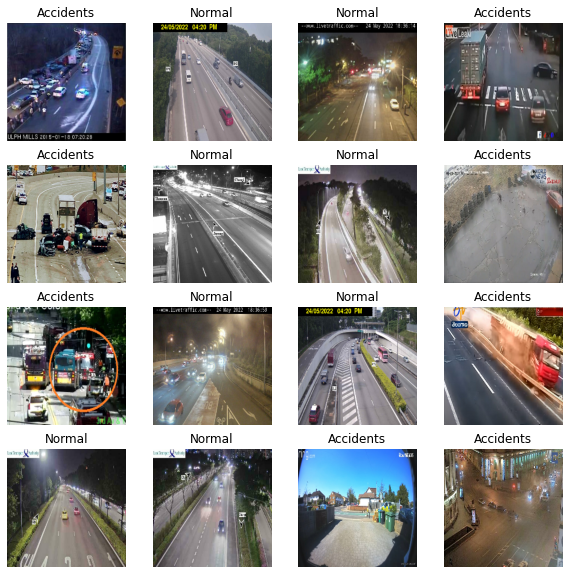

In [2]:
class_names = train_dataset.class_names

plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
  for i in range(16):
    ax = plt.subplot(4, 4, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

# Configure the Dataset For Performance

In [3]:
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

In [4]:
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

def transform_img_fn(path_list):
    out = []
    for img_path in path_list:
        img = tf_image.load_img(img_path, target_size=(224, 224))
        x = tf_image.img_to_array(img)
        x = np.expand_dims(x, axis=0)
        x = preprocess_input(x)
        out.append(x)
    return np.vstack(out)

# Load the MobileNetV2 Model that we trained

In [31]:
loaded_model = tf.keras.models.load_model(os.getcwd())
print("Model loaded:", loaded_model)

Model loaded: <keras.engine.functional.Functional object at 0x0000021D0EE1F4C0>


NameError: name 'IMG_SHAPE' is not defined

Predictions:
 [0 1 1 0 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 0 0 1 1 1 1 1 0 1 1 1 1]
Labels:
 [0 1 1 0 1 0 1 1 0 1 0 1 1 1 1 1 1 0 1 1 0 0 1 1 1 1 1 0 1 1 1 1]


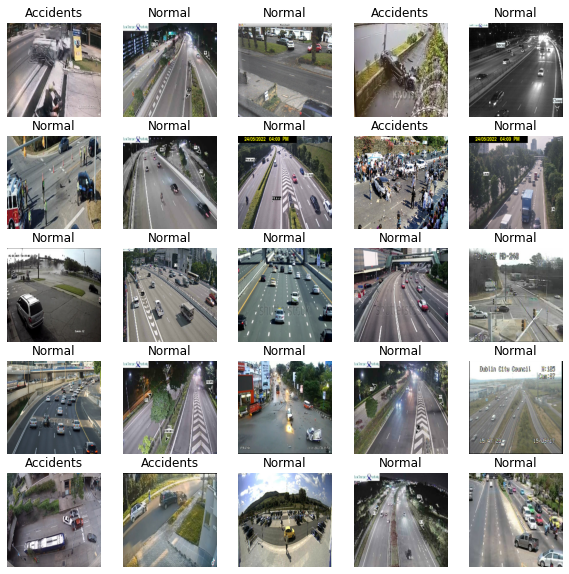

In [6]:
image_batch, label_batch = test_dataset.as_numpy_iterator().next()
predictions = loaded_model.predict_on_batch(image_batch).flatten()

# Apply a sigmoid since our model returns logits
predictions = tf.nn.sigmoid(predictions)
predictions = tf.where(predictions < 0.5, 0, 1)

print('Predictions:\n', predictions.numpy())
print('Labels:\n', label_batch)

plt.figure(figsize=(10, 10))
for i in range(25):
  ax = plt.subplot(5, 5, i + 1)
  plt.imshow(image_batch[i].astype("uint8"))
  plt.title(class_names[predictions[i]])
  plt.axis("off")

In [7]:
%load_ext autoreload
%autoreload 2
import os,sys
try:
    import lime
except:
    sys.path.append(os.path.join('..', '..')) # add the current directory
    import lime
from lime import lime_image

C:\Users\65860\Desktop\SoftwareEngineering\Year2\ITP\Project\Traffic_ML\test\Accidents\accident_92.jpg


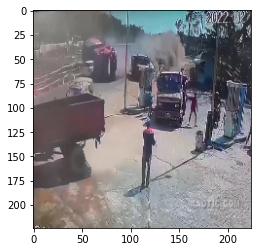

In [8]:
accident_dir = os.path.join(test_dir, 'Accidents')
img_test = os.path.join(accident_dir, 'accident_92.jpg')
print(img_test)
images = transform_img_fn([img_test])
plt.imshow(images[0] / 2 + 0.5)

In [48]:
%%time

explainer = lime_image.LimeImageExplainer()
# Hide color is the color for a superpixel turned OFF. Alternatively, if it is NONE, the superpixel will be replaced by the average of its pixels
explanation = explainer.explain_instance(images[0].astype('double'), loaded_model.predict, labels=(0, ), top_labels=5, hide_color=0, num_samples=1000)

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 194ms/step
CPU times: total: 1min 32s
Wall time: 23.3 s


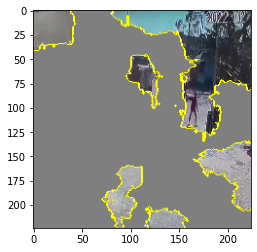

In [34]:
temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=True, num_features=10, hide_rest=True)
plt.imshow(mark_boundaries(temp / 2 + 0.5, mask))

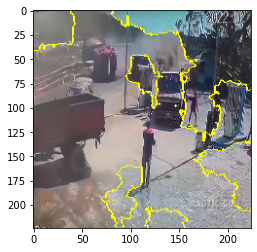

In [36]:
temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=True, num_features=20, hide_rest=False)
plt.imshow(mark_boundaries(temp / 2 + 0.5, mask))

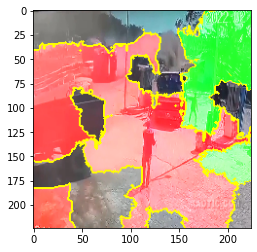

In [38]:
temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=False, num_features=20, hide_rest=False)
plt.imshow(mark_boundaries(temp / 2 + 0.5, mask))

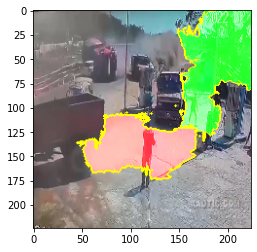

In [54]:
temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=False, num_features=100, hide_rest=False, min_weight=0.0001)
plt.imshow(mark_boundaries(temp / 2 + 0.5, mask))

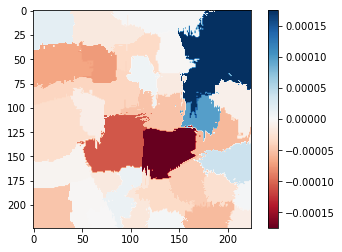

In [43]:
#Select the same class explained on the figures above.
ind =  explanation.top_labels[0]

#Map each explanation weight to the corresponding superpixel
dict_heatmap = dict(explanation.local_exp[ind])
heatmap = np.vectorize(dict_heatmap.get)(explanation.segments) 

#Plot. The visualization makes more sense if a symmetrical colorbar is used.
plt.imshow(heatmap, cmap = 'RdBu', vmin  = -heatmap.max(), vmax = heatmap.max())
plt.colorbar()

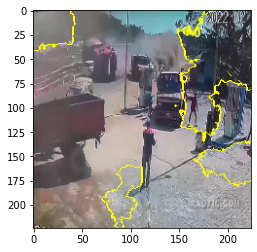

In [15]:
temp, mask = explanation.get_image_and_mask(0, positive_only=True, num_features=5, hide_rest=False)
plt.imshow(mark_boundaries(temp / 2 + 0.5, mask))

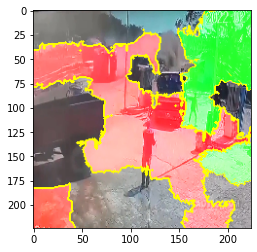

In [16]:
temp, mask = explanation.get_image_and_mask(0, positive_only=False, num_features=15, hide_rest=False)
plt.imshow(mark_boundaries(temp / 2 + 0.5, mask))

C:\Users\65860\Desktop\SoftwareEngineering\Year2\ITP\Project\Traffic_ML\test\Normal\normal_175.jpg


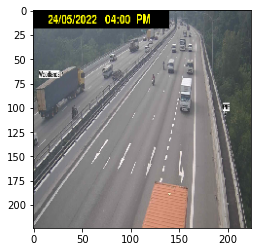

In [55]:
normal_dir = os.path.join(test_dir, 'Normal')
normal_img = os.path.join(normal_dir, 'normal_175.jpg')
print(normal_img)
normal_transformed = transform_img_fn([normal_img])
plt.imshow(normal_transformed[0] / 2 + 0.5)

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 154ms/step


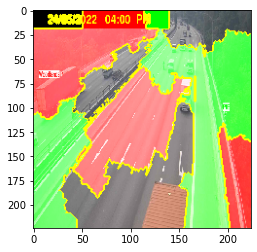

In [56]:
explanation_normal_175 = explainer.explain_instance(normal_transformed[0].astype('double'), loaded_model.predict, labels=(0, ), top_labels=5, hide_color=0, num_samples=1000)
temp1, mask1 = explanation_normal_175.get_image_and_mask(0, positive_only=False, num_features=20, hide_rest=False)
plt.imshow(mark_boundaries(temp1 / 2 + 0.5, mask1))

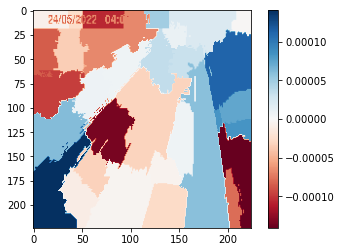

In [59]:
#Select the same class explained on the figures above.
ind =  explanation_normal_175.top_labels[0]

#Map each explanation weight to the corresponding superpixel
dict_heatmap = dict(explanation_normal_175.local_exp[ind])
heatmap = np.vectorize(dict_heatmap.get)(explanation_normal_175.segments) 

#Plot. The visualization makes more sense if a symmetrical colorbar is used.
plt.imshow(heatmap, cmap = 'RdBu', vmin  = -heatmap.max(), vmax = heatmap.max())
plt.colorbar()